<a href="https://colab.research.google.com/github/bruno-raffa/Quantum-exercises/blob/main/EV_Charger_Positioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EV CHARGER POSITIONING

This exercise deals with the D-wave example of a "EV-charger-placement". Here a problem's description from D-Wave:

Determining optimal locations to build new electric vehicle charging stations is a complex optimization problem. Many factors should be taken into consideration, like existing charger locations, points of interest (POIs), quantity to build, etc.

The challenge is coped on D-wave using a BQM. In this notebook instead the problem was solved using a **CQM**. 

This problem has been considered as a set of 4 independent objectives with binary variables that represent each potential new charging station location.

In [ ]:
! pip install dwave-ocean-sdk
! dwave setup

In [70]:
import matplotlib
import networkx as nx
import numpy as np
from dimod import ConstrainedQuadraticModel, Binary, quicksum, BinaryQuadraticModel, QuadraticModel
from dwave.system import LeapHybridCQMSampler
import random
try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

In [71]:
def set_up_scenario(w, h, num_poi, num_cs, seed):
    """Build scenario set up with specified parameters.
    
    Args:
        w (int): Width of grid
        h (int): Height of grid
        num_poi (int): Number of points of interest
        num_cs (int): Number of existing charging stations
        seed(in): seed for reproduction
    
    Returns:
        G (networkx graph): Grid graph of size w by h
        pois (list of tuples of ints): A fixed set of points of interest
        charging_stations (list of tuples of ints): 
            Set of current charging locations
        potential_new_cs_nodes (list of tuples of ints): 
            Potential new charging locations
    """

    G = nx.grid_2d_graph(w, h)
    nodes = list(G.nodes)

    random.seed(seed)

    # Identify a fixed set of points of interest
    pois = random.sample(nodes, k=num_poi)

    # Identify a fixed set of current charging locations
    charging_stations = random.sample(nodes, k=num_cs)

    # Identify potential new charging locations
    potential_new_cs_nodes = list(G.nodes() - charging_stations)

    return G, pois, charging_stations, potential_new_cs_nodes

In [72]:
def distance(a, b):
    return (a[0]**2 - 2*a[0]*b[0] + b[0]**2) + (a[1]**2 - 2*a[1]*b[1] + b[1]**2)

In [87]:
def build_cqm(potential_new_cs_nodes, num_poi, pois, num_cs, charging_stations, num_new_cs):
    """Build bqm that models our problem scenario for the hybrid sampler. 
    Args:
        potential_new_cs_nodes (list of tuples of ints):
            Potential new charging locations
        num_poi (int): Number of points of interest
        pois (list of tuples of ints): A fixed set of points of interest
        num_cs (int): Number of existing charging stations
        charging_stations (list of tuples of ints): 
            Set of current charging locations
        num_new_cs (int): Number of new charging stations desired
    
    Returns:
        cqm_np (BinaryQuadraticModel): QUBO model for the input scenario
    """

    
    # Tunable parameters
    obj1_priority = 1
    obj2_priority = 0.7
    obj3_priority = 0.5

    #Instantiate the models
    cqm = ConstrainedQuadraticModel()
    obj1 = BinaryQuadraticModel(vartype='BINARY')
    obj2 = BinaryQuadraticModel(vartype='BINARY')
    obj3 = BinaryQuadraticModel(vartype='BINARY')
    constraint = QuadraticModel()
    quadratic_terms = {}

  
    for i in range(len(potential_new_cs_nodes)):

      # Minimize average distance to POIs (ob1)
      cand_loc = potential_new_cs_nodes[i]
      avg_dist1 = sum(distance(cand_loc, loc) for loc in pois) / num_poi
      obj1.add_variable(i, avg_dist1)

      #Maximize distance to existing chargers (obj2)
      avg_dist2 = -sum(distance(cand_loc, loc)
                            for loc in charging_stations) / num_cs
      obj2.add_variable(i, avg_dist2)
      
      #Maximize distance to other new charging locations (obj3)
      for j in range(i+1, len(potential_new_cs_nodes)):
        ai = potential_new_cs_nodes[i]
        aj = potential_new_cs_nodes[j]
        dist = -distance(ai, aj)
        quadratic_terms[(i,j)] = dist
      obj3.add_quadratic_from(quadratic_terms)

      #Choose exactly num_new_cs new charging locations
      constraint.add_variable('BINARY', i)
      constraint.set_linear(i, 1)

    #Set the objective
    cqm.set_objective(obj1_priority * obj1 + obj2_priority * obj2 + obj3_priority * obj3)

    #Constraint : Choose exactly num_new_cs new charging locations
    cqm.add_constraint(constraint == num_new_cs, label='new charging locations')         
    return cqm
   

In [74]:
def printout_solution(pois, num_poi, charging_stations, num_cs, new_charging_nodes, num_new_cs):
    """Print solution statistics to command line.
    
    Args:
        pois (list of tuples of ints): A fixed set of points of interest
        num_poi (int): Number of points of interest
        charging_stations (list of tuples of ints): 
            A fixed set of current charging locations
        num_cs (int): Number of existing charging stations
        new_charging_nodes (list of tuples of ints): 
            Locations of new charging stations
        num_new_cs (int): Number of new charging stations desired
    
    Returns:
        None.
    """

    print("\nSolution returned: \n------------------")

    print("\nNew charging locations:\t\t\t\t", new_charging_nodes)

    if num_poi > 0:
        poi_avg_dist = [0] * len(new_charging_nodes)
        for loc in pois:
            for i, new in enumerate(new_charging_nodes):
                poi_avg_dist[i] += sum(abs(a - b) for a, b in zip(new, loc)) / num_poi
        print("Average distance to POIs:\t\t\t", poi_avg_dist)

    if num_cs > 0:
        old_cs_avg_dist = [sum(abs(a - b) for a, b in zip(new, loc) for loc in charging_stations) / num_cs for new in new_charging_nodes]
        print("Average distance to old charging stations:\t", old_cs_avg_dist)

    if num_new_cs > 1:
        new_cs_dist = 0
        for i in range(num_new_cs):
            for j in range(i+1, num_new_cs):
                new_cs_dist += abs(new_charging_nodes[i][0]-new_charging_nodes[j][0])+abs(new_charging_nodes[i][1]-new_charging_nodes[j][1])
        print("Distance between new chargers:\t\t\t", new_cs_dist)

In [75]:
def save_output_image(G, pois, charging_stations, new_charging_nodes):
    """ Create output image of solution scenario.
            - Black nodes: available space
            - Red nodes: current charger location
            - Nodes marked 'P': POI locations
            - Blue nodes: new charger locations
    Args:
        G (networkx graph): Grid graph of size w by h
        pois (list of tuples of ints): A fixed set of points of interest
        charging_stations (list of tuples of ints): 
            A fixed set of current charging locations
        new_charging_nodes (list of tuples of ints): 
            Locations of new charging stations
    
    Returns:
        None. Output saved to file "map.png".
    """

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('New EV Charger Locations')
    pos = {x: [x[0],x[1]] for x in G.nodes()}

    # Locate POIs in map
    poi_graph = G.subgraph(pois)
    poi_labels = {x: 'P' for x in poi_graph.nodes()}

    # Locate old charging stations in map
    cs_graph = G.subgraph(charging_stations)

    # Locate old charging stations at POIs in map
    poi_cs_list = set(pois) - (set(pois)-set(charging_stations))
    poi_cs_graph = G.subgraph(poi_cs_list)
    poi_cs_labels = {x: 'P' for x in poi_graph.nodes()}

    # Draw old map (left image)
    nx.draw_networkx(G, ax=ax1, pos=pos, with_labels=False, node_color='k', font_color='w')
    nx.draw_networkx(poi_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_labels, node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax1, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_cs_labels, node_color='r', font_color='w')

    # Draw new map (right image)
    new_cs_graph = G.subgraph(new_charging_nodes)
    nx.draw_networkx(G, ax=ax2, pos=pos, with_labels=False, node_color='k',
                        font_color='w')
    nx.draw_networkx(poi_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_labels,node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax2, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_cs_labels,  node_color='r', font_color='w')
    nx.draw_networkx(new_cs_graph, ax=ax2, pos=pos, with_labels=False,
                        node_color='#00b4d9', font_color='w')


In [80]:
#Set problem parameters
w = 15 
h = 15
num_poi = 3 
num_cs = 4
num_new_cs = 2
seed = 14

In [81]:
# Build large grid graph for city
G, pois, charging_stations, potential_new_cs_nodes = set_up_scenario(w, h, num_poi, num_cs, seed)

Submitting CQM to solver hybrid_constrained_quadratic_model_version1.

Solution returned: 
------------------

New charging locations:				 [(14, 1), (0, 14)]
Average distance to POIs:			 [16.666666666666668, 10.333333333333334]
Average distance to old charging stations:	 [16.0, 11.0]
Distance between new chargers:			 27
------------------------------------------


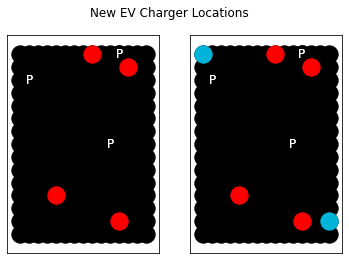

In [86]:
# Build CQM
cqm = build_cqm(potential_new_cs_nodes, num_poi, pois, num_cs, charging_stations, num_new_cs)

# Run CQM on HSS
sampler = LeapHybridCQMSampler()
print("Submitting CQM to solver {}.".format(sampler.solver.name))

# Sample from the model
sampleset = sampler.sample_cqm(cqm, label='EV-charger')
feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
if not len(feasible_sampleset):
    raise ValueError("No feasible solution found")

# Get the lowest feasible energy solution and store it the solution variable
best = feasible_sampleset.first
new_charging_nodes = [potential_new_cs_nodes[key] for key, val in best.sample.items() if val==1.0]

# Print results to commnand-line for user
printout_solution(pois, num_poi, charging_stations, num_cs, new_charging_nodes, num_new_cs)

print('------------------------------------------')
# Create scenario output image
save_output_image(G, pois, charging_stations, new_charging_nodes)